In [1]:
import os
from matrix_client.api import MatrixHttpApi
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from matrixstats import *

In [2]:
token = os.environ["ACCESS_TOKEN"]

homeserver = "https://matrix.cadair.com"
stop_time = None

api = MatrixHttpApi(homeserver, token=token)

In [3]:
ids = {#'astropy': get_rooms_in_community(api, "+astropy:openastronomy.org"),
       'sunpy': get_rooms_in_space(api, "#sunpy-space:openastronomy.org")}

In [47]:
events, messages = load_messages(api, ids, refresh_cache=False, stop_time=stop_time, ignore_github=True, ignore_rooms=["Virtual Solar Observatory", "SunPy GitHub"])

/home/stuart/Git/chat_stats/matrixstats.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m.loc[:, 'usender'] = [a.split(":")[0][1:].split("_")[-1] if "slack" in a else a for a in m['sender']]
/home/stuart/Git/chat_stats/matrixstats.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  m.loc[:, 'usender'] = [a.split(":")[0][1:].split("_")[-1] if "slack" in a else a for a in m['sender']]
/home/stuart/Git/chat_stats/matrixstats.py:265: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

In [48]:
# We ignore emtpy rooms
non_empty_messages = {group: {room: m for room, m in gmessages.items() if not m.empty}
                      for group, gmessages in messages.items()}
all_messages = {group: pd.concat(gmessages).reset_index(level=0)
                for group, gmessages in non_empty_messages.items()}

# Instant Messaging

All public channels in astropy.slack.org is bridged to chat.openastronomy.org

Matrix keeps all history which can requested from any matrix server in the room.

https://view.matrix.org/alias/%23astropy_general:openastronomy.org

Therefore... STATISTICS!

https://github.com/cadair/chat_stats

# Number of Channels

In [49]:
for group, df in messages.items():
    print(group, len(df))

sunpy 14


# Number of Messages per Channel

In [50]:
def get_len_key(adict, reverse=True):
    n_messages = {}
    for k in sorted(adict, key=lambda k: len(adict[k]), reverse=reverse):
        m = adict[k]
        n_messages[k] = len(m)
    return n_messages

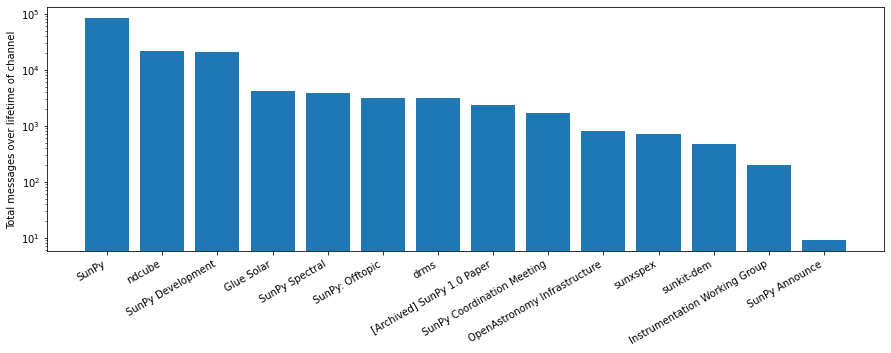

In [51]:
fig = plt.figure(figsize=(15,5))
n_messages = get_len_key(flatten_dicts(messages))
plt.bar(list(range(len(n_messages))), list(n_messages.values()), tick_label=list(n_messages.keys()))
fig.autofmt_xdate()
#plt.axhline(100, linestyle="--", linewidth=1, color="k")
plt.semilogy()
_ = plt.ylabel("Total messages over lifetime of channel")

In [52]:
print_sorted_len(flatten_dicts(messages))

SunPy: 84437
ndcube: 21929
SunPy Development: 20334
Glue Solar: 4211
SunPy Spectral: 3809
SunPy: Offtopic: 3115
drms: 3069
[Archived] SunPy 1.0 Paper: 2335
SunPy Coordination Meeting: 1711
OpenAstronomy Infrastructure: 800
sunxspex: 721
sunkit-dem: 463
Instrumentation Working Group: 200
SunPy Announce: 9


In [53]:
channel_creation = {k:v.index[-1] for k, v in flatten_dicts(events).items()}

print_sorted_value(channel_creation, reverse=False)

SunPy Announce: 2016-07-18 15:10:49.843000
drms: 2017-05-08 15:43:39.456000
ndcube: 2017-05-22 16:04:46.728000
SunPy: 2017-06-20 19:55:48.536000
SunPy Development: 2018-04-23 13:33:35.460000
[Archived] SunPy 1.0 Paper: 2018-11-20 12:41:35.179000
SunPy Spectral: 2019-05-08 18:10:08.712000
sunxspex: 2019-06-19 22:59:08.260000
Instrumentation Working Group: 2019-10-22 19:07:25.364000
SunPy Coordination Meeting: 2019-11-19 19:26:38.119000
SunPy: Offtopic: 2020-02-13 17:06:12.816000
Glue Solar: 2020-03-19 14:27:38.150000
sunkit-dem: 2020-04-21 17:27:57.711000
OpenAstronomy Infrastructure: 2022-02-24 14:24:28.850000


In [54]:
messages_per_day = {group: pd.DataFrame({k:m['body'].resample("1D").count() for k,m in gm.items() if not m.empty}).fillna(0)
                    for group, gm in messages.items()}

In [55]:
messages_per_week = {group: pd.DataFrame({k:m['body'].resample("1W").count() for k,m in gm.items() if not m.empty}).fillna(0)
                     for group, gm in messages.items()}

In [56]:
total_mpd = {group: df.sum(axis=1) for group, df in messages_per_day.items()}
total_mpw = {group: df.sum(axis=1) for group, df in messages_per_week.items()}

## Total Messages per Week

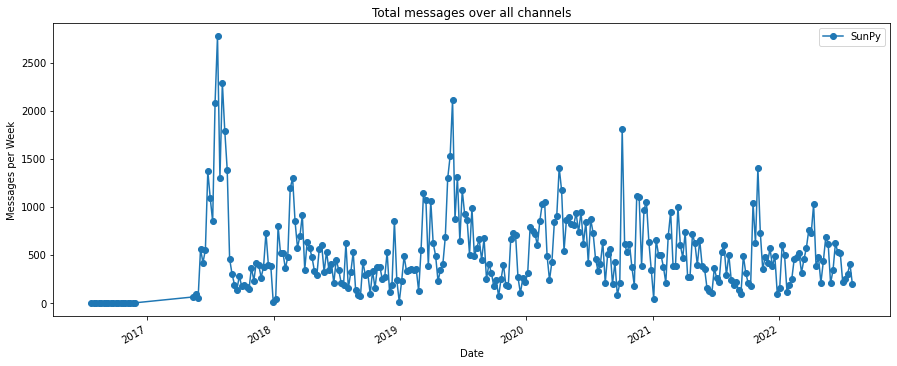

In [57]:
fig, ax = plt.subplots(figsize=(15,6))
ax.plot(total_mpw['sunpy'].index, total_mpw['sunpy'], "-o", label="SunPy")
#ax.plot(total_mpw['astropy'].index, total_mpw['astropy'], "-o", label="Astropy")
fig.autofmt_xdate()
plt.legend()
ax.set_ylabel("Messages per Week")
ax.set_xlabel("Date")
ax.set_title("Total messages over all channels")
None

In [58]:
for key in messages_per_week["sunpy"]:
    print(key)

Glue Solar
Instrumentation Working Group
OpenAstronomy Infrastructure
SunPy
SunPy Announce
SunPy Coordination Meeting
SunPy Development
SunPy Spectral
SunPy: Offtopic
[Archived] SunPy 1.0 Paper
drms
ndcube
sunkit-dem
sunxspex


In [108]:
ordered_columns = messages_per_week["sunpy"].sum(axis=0).sort_values(ascending=False).index.tolist()

In [109]:
messages_per_week["sunpy"] = messages_per_week["sunpy"][ordered_columns]

In [112]:
channel_colours = plt.colormaps['tab20c'](np.linspace(0.15, 0.85, len(ordered_columns)))

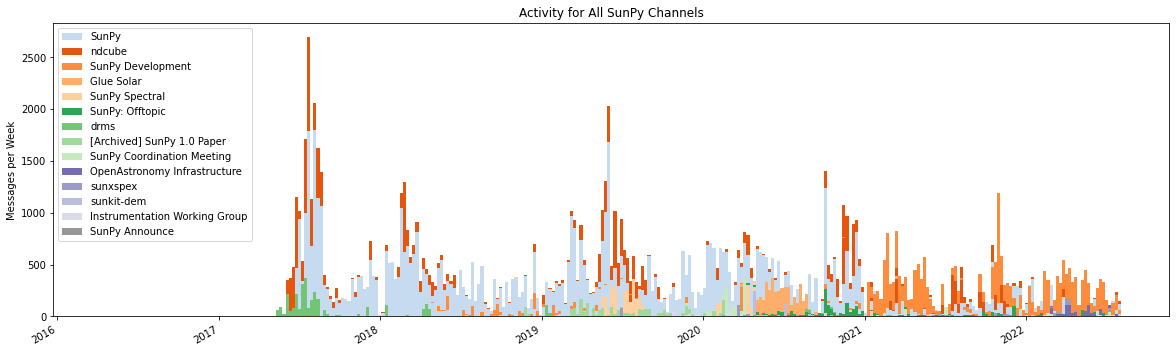

In [113]:
fig, ax = plt.subplots(figsize=(20,6))
previous_channel = None
index = messages_per_week["sunpy"].index
bottom = running_total = None
for channel, colour in zip(messages_per_week["sunpy"], channel_colours):
    data = messages_per_week["sunpy"][channel]
    ax.bar(index, data, bottom=running_total, label=channel, width=np.timedelta64(7, 'D'), color=colour)
    running_total = bottom + data if bottom is not None else data

fig.autofmt_xdate()
plt.legend(loc='upper left')
ax.set_ylabel("Messages per Week")
ax.set_title("Activity for All SunPy Channels")
ax.set_xbound(lower=ax.axis()[0]-100)
None

## Most Active Senders

In [115]:
active_senders = calculate_active_senders(api, all_messages, 20, "@slack_astropy_{s}:openastronomy.org")

/home/stuart/Git/chat_stats/matrixstats.py:298: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  df.loc[:top_n, 'display_name'] = get_display_names(api, df.index[:top_n], template=template)


In [118]:
# TODO: workout how to deduplicate users based on mxid
usender_map = {'@Cadair:matrix.org': '@cadair:cadair.com', '@cadair:openastronomy.org': '@cadair:cadair.com'}

In [119]:
active_senders['sunpy'].iloc[:, 1:]

,number_of_messages,mean_body_len,median_body_len
display_name,,,
Cadair*,36765,55.790073,40.0
Nabobalis*,27105,57.417747,39.0
DanRyan37*,9071,95.861102,50.0
Cadair*,8177,41.413179,32.0
Github [@Cadair:matrix.org]*,6820,160.744868,144.0
Akira*,6651,100.590378,44.0
wtbarnes*,5511,99.366841,64.0
ayshih*,3899,119.184466,86.0
dstansby*,3809,84.225603,65.0


In [120]:
all_senders = {}
for group, gmessages in all_messages.items():
    senders = pd.DataFrame(gmessages.groupby("usender").count()['body'].sort_values(ascending=False))
    all_senders[group] = senders

# Senders per Week

In [122]:
senders_per_day = {group: am.resample("1D").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}
senders_per_week = {group: am.resample("1W").agg({'usender': 'nunique'})['usender'] for group, am in all_messages.items()}

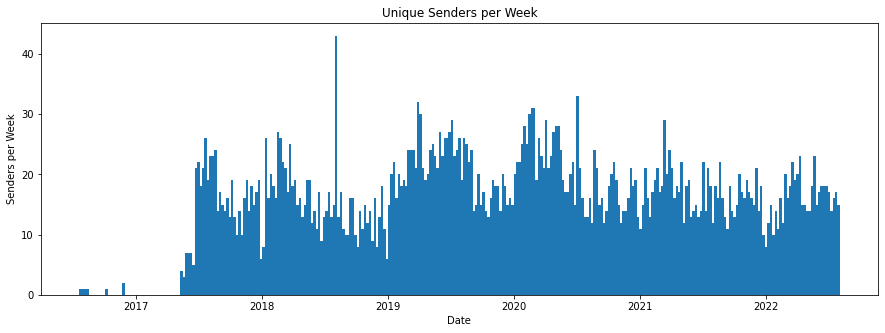

In [141]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Unique Senders per Week")
ax.bar(senders_per_week['sunpy'].index, senders_per_week['sunpy'], width=np.timedelta64(7, 'D'))
ax.set_ylabel("Senders per Week")
_ = ax.set_xlabel("Date")
#plt.xlim((2490, 2555))

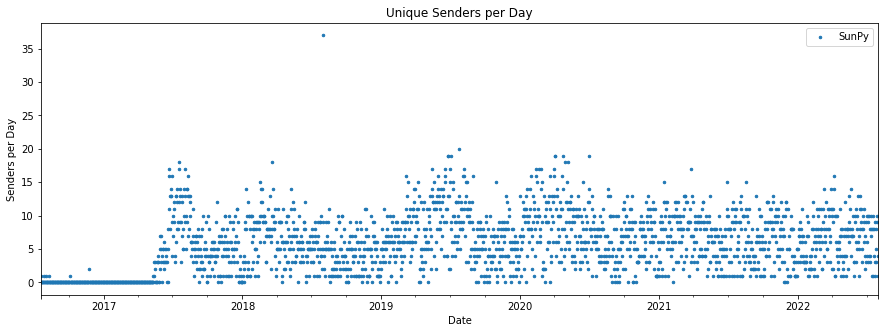

In [147]:
fig, ax = plt.subplots(figsize=(15,5))

ax.set_title("Unique Senders per Day")
senders_per_day['sunpy'].plot(ax=ax, label="SunPy", style=".", ms=5)
ax.set_ylabel("Senders per Day")
ax.set_xlabel("Date")
#plt.xlim((2490, 2555))
_ = plt.legend()

## Messages per Day vs Senders per Day

ValueError: x and y must have same first dimension, but have shapes (2034,) and (2203,)

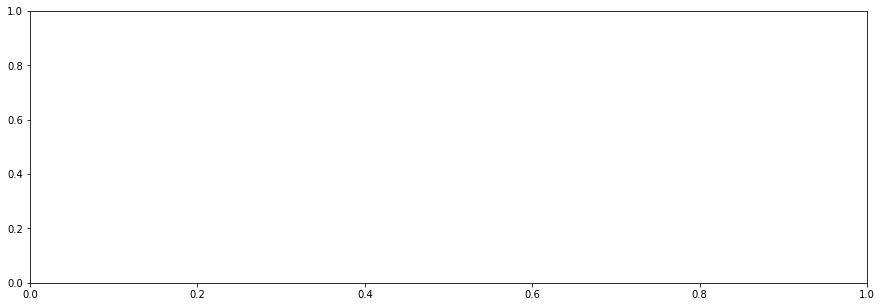

In [143]:
plt.figure(figsize=(15,5))

sp = plt.plot(total_mpd['sunpy'], senders_per_day['sunpy'], ".", color="C0", ms=10)

plt.xlabel("Messages per Day")
plt.ylabel("Senders per Day")